In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Firm level co-export, co-import

In [2]:
# df = pd.read_csv('data/sample-data_edit.csv')
# CN_full = pd.read_csv('data/CN_full.csv')
# CPA_full = pd.read_csv('data/CPA_full.csv')


# df = df.merge(CN_full[['CN ID 8', 'CN ID 1', 'CN label 1']])

In [3]:
### Data prepare
# Load 

df = pd.read_csv('./../../data/processed/CN_ID_4_FY.csv')
df = df.loc[df.IMPORT == 0]


df = df.groupby(['ID', 'IMPORT', 'CN ID 4'])['VART'].sum().reset_index()
df['CN ID 4'] = df['CN ID 4'].astype(str)

In [4]:
#### Prune
# Take the largest 95%
df['ID_IMPORT'] = df['ID'].astype(str) + '_' + df['IMPORT'].astype(str)
sum_ = df.groupby(['ID_IMPORT'])['VART'].sum().sort_values(ascending = False)
cs = sum_.cumsum()/sum_.sum()
large_firms = cs.loc[(cs<.95)].index

# Filtered data
df_large_firms = df.loc[df.ID_IMPORT.isin(large_firms)]

In [5]:
# prune the number of products

df_lf = df_large_firms.copy()

CN_full = pd.read_csv('./../../data/CN_full.csv', encoding = 'utf-8')
CN_full['CN ID 4'] = CN_full['CN ID 4'].astype(str)

CN_4_1 = CN_full[['CN ID 4', 'CN ID 1']].drop_duplicates()
CN_4_1['CN ID 4'] = CN_4_1['CN ID 4'].astype(str)

sum_ = df_lf.groupby(['CN ID 4'])['VART'].sum().sort_values(ascending = False)
cs = sum_.cumsum()/sum_.sum()

# cs.reset_index().reset_index().plot('index', 'VART') #plot

In [6]:
#ok. separate data into the small products, replacing them by the section title, and the large products, keeping them as they are
# This will be called CN_custom_ID
df_lf['CN_custom_ID'] = df_lf['CN ID 4']

smallp = df_lf.loc[df_lf['CN ID 4'].isin(cs[400:].index)]
largep = df_lf.loc[df_lf['CN ID 4'].isin(cs[:400].index)]
largep = largep.drop('CN ID 4', axis = 1)

smallp = smallp.merge(CN_4_1.rename(columns = {'CN ID 4': 'CN_custom_ID'}))
smallp['CN_custom_ID'] = smallp['CN ID 1']
smallp = smallp.drop('CN ID 1', axis = 1)

smallp = smallp.groupby([u'ID', u'IMPORT', u'ID_IMPORT', u'CN_custom_ID'])[u'VART'].sum().reset_index()

df_pruned = pd.concat([largep, smallp])

In [7]:
# Drop firms with only one product

nunique_prods = df_pruned.groupby('ID_IMPORT')['CN_custom_ID'].nunique()
df_multip = df_pruned.loc[~df_pruned.ID_IMPORT.isin(nunique_prods.loc[nunique_prods == 1].index)]

In [8]:
# Done pruning.


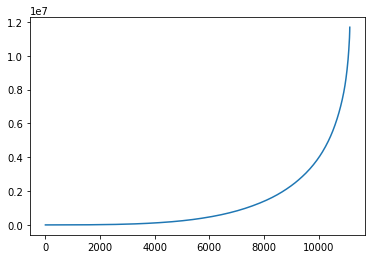

In [9]:

n = df_multip.groupby('ID_IMPORT').count().iloc[:, 1].sort_values()
plt.plot(range(len(n)), (n*(n-1)/2).cumsum())
# there is a way to reconstruct a large part of the network using small number of rows.
# for example, 26122 less diversified firms will give 100 m edge rows, 14798 will give 10m rows.

# ((n*(n-1)/2).cumsum() < 1e8).sum()


In [10]:
n = df_multip.groupby('ID_IMPORT').count().iloc[:, 1].sort_values()

df_multip_lowd = df_multip.loc[df_multip.ID_IMPORT.isin(n.head(10000).index)]
df_multip_lowd.sort_values(by = ['ID_IMPORT', 'CN_custom_ID'])

df_multip_lowd['CN_custom_ID'] = df_multip_lowd['CN_custom_ID'].astype(str)

df_multip_lowd = df_multip_lowd.set_index(['CN_custom_ID', 'ID_IMPORT'])
df_multip_lowd['VART'] = df_multip_lowd.groupby(level = 0)['VART'].apply(lambda x: x/x.sum())

df_multip_lowd = df_multip_lowd.reset_index()

In [11]:
df1 = pd.DataFrame(df_multip_lowd.reset_index().groupby('ID_IMPORT')['CN_custom_ID'].unique())

from itertools import permutations 

chunk_list = []
for i, row in df1.iterrows():
    perm = list(permutations(row.CN_custom_ID, 2) )
    sorted_ = [sorted(p) for p in perm] 
    
    # make it upper diagonal
    q = np.empty(len(sorted_), dtype='object')
    q[:] = sorted_
    unique = np.unique(q)
    
    chunk = pd.DataFrame(sorted_, columns = ['source','target'], dtype = str)
    chunk['ID_IMPORT'] = i
    chunk_list += [chunk]
result = pd.concat(chunk_list)

result = result.merge(df_multip_lowd[['ID_IMPORT', 'CN_custom_ID', 'VART']], left_on = ['source', 'ID_IMPORT'], right_on = ['CN_custom_ID', 'ID_IMPORT']
                     ).merge(df_multip_lowd[['ID_IMPORT', 'CN_custom_ID', 'VART']], left_on = ['target', 'ID_IMPORT'], right_on = ['CN_custom_ID', 'ID_IMPORT'])

result['weight'] = result['VART_x'] * result['VART_y']

result = result.drop(['CN_custom_ID_x', 'CN_custom_ID_y', 'VART_x', 'VART_y'], axis = 1)

print(result.shape)

(7923812, 4)


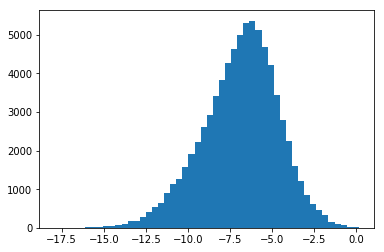

In [12]:
edges_df = result.groupby(['source','target'])['weight'].sum().reset_index()

edges_df.sort_values(by = 'weight', ascending = False)
edges_df['log_weight'] = np.log10(edges_df['weight']).replace(-np.inf, np.nan)
edges_df = edges_df.dropna()
plt.hist(edges_df.log_weight, 50)
plt.show()

In [13]:
# import networkx as nx
# import collections

# # see threshold... probably 15 is ok
# for th in np.arange(13, 18, .5):
#     print(th) 
#     fig, ax = plt.subplots()
#     G = nx.from_pandas_edgelist(edges_df.loc[edges_df.log_weight > th], 'CN_source', 'CN_target', ['log_weight'])

#     degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
#     # print "Degree sequence", degree_sequence
#     degreeCount = collections.Counter(degree_sequence)
#     deg, cnt = zip(*degreeCount.items())

#     ax.plot(deg, cnt, color='b', marker = '.', lw = 0)

#     ax.set_title("Degree Histogram")
#     ax.set_ylabel("Count")
#     ax.set_xlabel("Degree")
#     ax.set_xticks([d + 0.4 for d in deg])
#     ax.set_xticklabels(deg)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     plt.show()

In [14]:
import networkx as nx
import collections

import matplotlib.colors as mcolors
import libraries.d3plus2 as d3plus

###  Network functions

import matplotlib.pyplot as plt

def color_from_series(df, ix_col, val_col, cmap = plt.cm.RdYlGn):
    import matplotlib.colors as mcolors

    # create color reference
    qlo = df[val_col].min()#quantile(.2)
    qhi = df[val_col].max()#quantile(.8)
    norm = mcolors.Normalize(vmin=qlo, vmax=qhi, clip=True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap=cmap)
    df['color'] = df[val_col].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x))) 
    color = df[[ix_col, 'color']]
    return color

from pylab import *

def color_custom(df, val_col = 'group'):
    colors = df[['CN ID 1',val_col]].drop_duplicates()[val_col]

    cmap = cm.get_cmap('tab10', len(colors))
    col_strings = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        col_strings += [matplotlib.colors.rgb2hex(rgb)]
    col_strings[-1] = '#bebebe'

    colors = df[['CN ID 1', val_col]].drop_duplicates()
    colors['color'] = col_strings
    return colors

def network_info(nodes, edges, pos, label_info, ix_col, label_col, scaling_fix_param = 600):
    # Networkx / Find layout
    # nodes
    pos_df = pd.DataFrame(pos, index = ['x', 'y']).T; pos_df.index = pos_df.index.astype(str)
    nodes_wpos = nodes.merge(pos_df.reset_index().rename(columns = {'index': columns})).merge(label_info)
    nodes_wpos['y'] = -nodes_wpos['y']

    nodes_ = nodes_wpos.reset_index()[['CN_custom_ID','index','x', 'y', label_col, 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
#     nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
    nodes_[['x', 'y']] = scaling_fix_param * nodes_[['x', 'y']]

    nodes_['presence'] = True

    edges['edge_tuple'] = list(zip(edges.source, edges.target))
    edges['edge_tuple_rev'] = list(zip(edges.target, edges.source))
    edges_triangles = edges.loc[edges.edge_tuple.isin(G.edges()) | edges.edge_tuple_rev.isin(G.edges())]

    links = edges_triangles.reset_index()
    links['target'] = links['target']#.astype(str).str.zfill(4)
    links['source'] = links['source']#.astype(str).str.zfill(4)
    
    network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
    
    return nodes_, links, network

## Exports

<IPython.core.display.Javascript object>

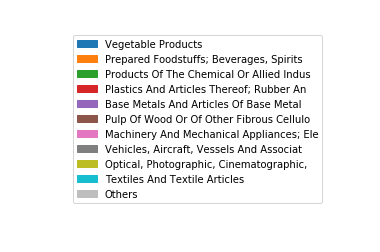

In [15]:

th = -3.6

G = nx.from_pandas_edgelist(edges_df.loc[edges_df.log_weight > th], 'source', 'target', ['log_weight'])

G = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]

# nodes dataframe.
# get level 1 classification column
nodes_df = pd.DataFrame(pd.Series(G.nodes()), columns = ['CN_custom_ID'])
nodes_df = nodes_df.merge(CN_4_1, left_on = ['CN_custom_ID'], right_on = ['CN ID 4'], how = 'left')
nodes_df['CN ID 1'] = nodes_df['CN ID 1'].fillna(nodes_df.CN_custom_ID)
nodes_df = nodes_df.drop('CN ID 4', axis = 1)

# Group smaller CN ID 1 into 'Others' group 
groupsizes = nodes_df['CN ID 1'].value_counts().index

large_gps = nodes_df.loc[nodes_df['CN ID 1'].isin(groupsizes[:10])]
other = nodes_df.loc[nodes_df['CN ID 1'].isin(groupsizes[10:])]
other['CN ID 1'] = 'Other'

nodes_df = pd.concat([large_gps, other])

nodes_df['group'] = nodes_df['CN ID 1'].rank(method = 'dense')

###

nodes = nodes_df
ix_col = 'CN ID 1'
# cmap = plt.cm.Set2
# color_df = color_from_series(nodes, ix_col, val_col = 'group', cmap = cmap)
color_df = color_custom(nodes, 'group')

nodes = nodes.merge(color_df)
present_nodes = np.intersect1d(nodes['CN_custom_ID'].values, G.nodes())
        
pos = nx.spring_layout(G)
pos = dict([(n, pos[n]) for n in present_nodes]) #refresh positions

# Label info
CN_full['CN ID 4'] = CN_full['CN ID 4'].astype(str)
labels_4 = nodes.merge(CN_full[['CN ID 4', 'CN label 4']].drop_duplicates(), left_on = 'CN_custom_ID', right_on = 'CN ID 4')
labels_1 = nodes.drop('CN ID 1', axis = 1).merge(CN_full[['CN ID 1', 'CN label 1']].drop_duplicates(), left_on = 'CN_custom_ID', right_on = 'CN ID 1')
labels_1['CN label 1'] = 'Rest of '+labels_1['CN label 1']
label_info = pd.concat([labels_1, labels_4])
label_info['CN_custom_label'] = label_info['CN label 4'].fillna(label_info['CN label 1'])
label_info = label_info.dropna(axis =1)
label_col = 'CN_custom_label'
columns = 'CN_custom_ID'
####

nodes_, edges_, network = network_info(nodes, edges_df, pos, label_info, ix_col, label_col)

ps = d3plus.ProductSpace(
id="name",
name=label_col,
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="CN_custom_ID")
ps.draw(nodes_)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color_summary = color_df.drop_duplicates().merge(CN_full[['CN ID 1', 'CN label 1']].drop_duplicates(), how = 'left')

legend_elements = [Patch([0], [0], color=c) for c in color_summary.color.values]
labels = [l[:40] for l in color_summary['CN label 1'].fillna('Others').values]

# Create the figure
plt.legend(legend_elements, labels, loc='center')
plt.axis('off')
plt.show()

## Imports

In [16]:
# Load 

df = pd.read_csv('./../../data/processed/CN_ID_4_FY.csv')
df = df.loc[df.IMPORT == 1]


df = df.groupby(['ID', 'IMPORT', 'CN ID 4'])['VART'].sum().reset_index()
df['CN ID 4'] = df['CN ID 4'].astype(str)

# Take the largest 95%
df['ID_IMPORT'] = df['ID'].astype(str) + '_' + df['IMPORT'].astype(str)
sum_ = df.groupby(['ID_IMPORT'])['VART'].sum().sort_values(ascending = False)
cs = sum_.cumsum()/sum_.sum()
large_firms = cs.loc[(cs<.95)].index

# Filtered data
df_large_firms = df.loc[df.ID_IMPORT.isin(large_firms)]


In [17]:

# prune the number of products

df_lf = df_large_firms.copy()

CN_full = pd.read_csv('./../../data/CN_full.csv', encoding = 'utf-8')
CN_full['CN ID 4'] = CN_full['CN ID 4'].astype(str)

CN_4_1 = CN_full[['CN ID 4', 'CN ID 1']].drop_duplicates()
CN_4_1['CN ID 4'] = CN_4_1['CN ID 4'].astype(str)

sum_ = df_lf.groupby(['CN ID 4'])['VART'].sum().sort_values(ascending = False)
cs = sum_.cumsum()/sum_.sum()

#ok. separate data into the small products, replacing them by the section title, and the large products, keeping them as they are
# This will be called CN_custom_ID
df_lf['CN_custom_ID'] = df_lf['CN ID 4']

smallp = df_lf.loc[df_lf['CN ID 4'].isin(cs[400:].index)]
largep = df_lf.loc[df_lf['CN ID 4'].isin(cs[:400].index)]
largep = largep.drop('CN ID 4', axis = 1)

smallp = smallp.merge(CN_4_1.rename(columns = {'CN ID 4': 'CN_custom_ID'}))
smallp['CN_custom_ID'] = smallp['CN ID 1']
smallp = smallp.drop('CN ID 1', axis = 1)

smallp = smallp.groupby([u'ID', u'IMPORT', u'ID_IMPORT', u'CN_custom_ID'])[u'VART'].sum().reset_index()

df_pruned = pd.concat([largep, smallp])

# Drop firms with only one product

nunique_prods = df_pruned.groupby('ID_IMPORT')['CN_custom_ID'].nunique()
df_multip = df_pruned.loc[~df_pruned.ID_IMPORT.isin(nunique_prods.loc[nunique_prods == 1].index)]

n = df_multip.groupby('ID_IMPORT').count().iloc[:, 1].sort_values()

df_multip_lowd = df_multip.loc[df_multip.ID_IMPORT.isin(n.head(10000).index)]
df_multip_lowd.sort_values(by = ['ID_IMPORT', 'CN_custom_ID'])

df_multip_lowd['CN_custom_ID'] = df_multip_lowd['CN_custom_ID'].astype(str)

df_multip_lowd = df_multip_lowd.set_index(['CN_custom_ID', 'ID_IMPORT'])
df_multip_lowd['VART'] = df_multip_lowd.groupby(level = 0)['VART'].apply(lambda x: x/x.sum())

df_multip_lowd = df_multip_lowd.reset_index()

df1 = pd.DataFrame(df_multip_lowd.reset_index().groupby('ID_IMPORT')['CN_custom_ID'].unique())

from itertools import permutations 

chunk_list = []
for i, row in df1.iterrows():
    perm = list(permutations(row.CN_custom_ID, 2) )
    sorted_ = [sorted(p) for p in perm] 
    
    # make it upper diagonal
    q = np.empty(len(sorted_), dtype='object')
    q[:] = sorted_
    unique = np.unique(q)
    
    chunk = pd.DataFrame(sorted_, columns = ['source','target'], dtype = str)
    chunk['ID_IMPORT'] = i
    chunk_list += [chunk]
result = pd.concat(chunk_list)

result = result.merge(df_multip_lowd[['ID_IMPORT', 'CN_custom_ID', 'VART']], left_on = ['source', 'ID_IMPORT'], right_on = ['CN_custom_ID', 'ID_IMPORT']
                     ).merge(df_multip_lowd[['ID_IMPORT', 'CN_custom_ID', 'VART']], left_on = ['target', 'ID_IMPORT'], right_on = ['CN_custom_ID', 'ID_IMPORT'])

result['weight'] = result['VART_x'] * result['VART_y']

result = result.drop(['CN_custom_ID_x', 'CN_custom_ID_y', 'VART_x', 'VART_y'], axis = 1)

print(result.shape)

edges_df = result.groupby(['source','target'])['weight'].sum().reset_index()
edges_df['log_weight'] = np.log10(edges_df['weight']).replace(-np.inf, np.nan)
edges_df = edges_df.dropna()

(2036238, 4)


<IPython.core.display.Javascript object>

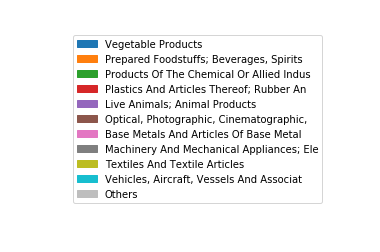

In [18]:

import matplotlib.colors as mcolors
import libraries.d3plus2 as d3plus

th = -2.65

G = nx.from_pandas_edgelist(edges_df.loc[edges_df.log_weight > th], 'source', 'target', ['log_weight'])

G = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]

# nodes dataframe.
# get level 1 classification column
nodes_df = pd.DataFrame(pd.Series(G.nodes()), columns = ['CN_custom_ID'])
nodes_df = nodes_df.merge(CN_4_1, left_on = ['CN_custom_ID'], right_on = ['CN ID 4'], how = 'left')
nodes_df['CN ID 1'] = nodes_df['CN ID 1'].fillna(nodes_df.CN_custom_ID)
nodes_df = nodes_df.drop('CN ID 4', axis = 1)

# Group smaller CN ID 1 into 'Others' group 
groupsizes = nodes_df['CN ID 1'].value_counts().index

large_gps = nodes_df.loc[nodes_df['CN ID 1'].isin(groupsizes[:10])]
other = nodes_df.loc[nodes_df['CN ID 1'].isin(groupsizes[10:])]
other['CN ID 1'] = 'Other'

nodes_df = pd.concat([large_gps, other])

nodes_df['group'] = nodes_df['CN ID 1'].rank(method = 'dense')

###

nodes = nodes_df
ix_col = 'CN ID 1'
# cmap = plt.cm.Set2
# color_df = color_from_series(nodes, ix_col, val_col = 'group', cmap = cmap)
color_df = color_custom(nodes, 'group')

nodes = nodes.merge(color_df)
present_nodes = np.intersect1d(nodes['CN_custom_ID'].values, G.nodes())
        
pos = nx.spring_layout(G)
pos = dict([(n, pos[n]) for n in present_nodes]) #refresh positions

# Label info
CN_full['CN ID 4'] = CN_full['CN ID 4'].astype(str)
labels_4 = nodes.merge(CN_full[['CN ID 4', 'CN label 4']].drop_duplicates(), left_on = 'CN_custom_ID', right_on = 'CN ID 4')
labels_1 = nodes.drop('CN ID 1', axis = 1).merge(CN_full[['CN ID 1', 'CN label 1']].drop_duplicates(), left_on = 'CN_custom_ID', right_on = 'CN ID 1')
labels_1['CN label 1'] = 'Rest of '+labels_1['CN label 1']
label_info = pd.concat([labels_1, labels_4])
label_info['CN_custom_label'] = label_info['CN label 4'].fillna(label_info['CN label 1'])
label_info = label_info.dropna(axis =1)
label_col = 'CN_custom_label'
columns = 'CN_custom_ID'
####

nodes_, edges_, network = network_info(nodes, edges_df, pos, label_info, ix_col, label_col)

ps = d3plus.ProductSpace(
id="name",
name=label_col,
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="CN_custom_ID")
ps.draw(nodes_)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color_summary = color_df.drop_duplicates().merge(CN_full[['CN ID 1', 'CN label 1']].drop_duplicates(), how = 'left')

legend_elements = [Patch([0], [0], color=c) for c in color_summary.color.values]
labels = [l[:40] for l in color_summary['CN label 1'].fillna('Others').values]

# Create the figure
plt.legend(legend_elements, labels, loc='center')
plt.axis('off')
plt.show()

In [19]:
xx

NameError: name 'xx' is not defined

## End

In [ ]:
import networkx as nx

edges = nw_data.loc[edges_df['weight'] > .55].reset_index()

G = nx.from_pandas_dataframe(edges, 'rank_ID', 'rank_ID_', ['weight'])
grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)


In [ ]:


l = len(df1)

df1 = df1.reset_index()[['rank_ID', 'sets']]

df2 = df1.add_suffix('_')

l = len(df2)

# df1.merge(df2, left_on= 'rank_ID', right_on = 'rank_ID_', how = 'outer')
df1 = pd.concat([df1]*l).reset_index(drop = True)
df2 = pd.concat([df2]*l).sort_values(by = 'rank_ID_').reset_index(drop = True)

df = pd.concat([df1, df2], axis = 1)

df['inters'] = [x[0] & x[1] for x in zip(df['sets'], df['sets_'])]

def similarity(x, y):
    a = np.true_divide(len(x & y),len(x))
    b = np.true_divide(len(x & y),len(y))
    return min(a, b)
    
df['inters_ct'] = [similarity(x[0], x[1]) for x in zip(df['sets'], df['sets_'])]

In [ ]:
d_df = df.set_index(['rank_ID', 'rank_ID_'])['inters_ct'].unstack()

# import seaborn as sns
# cm = sns.light_palette("green", as_cmap=True)
# s = d_df.round(2).style.background_gradient(cmap=cm, low=0, high=.5)
# s

nw_data = pd.DataFrame(d_df.stack(), columns = ['weight'])
nw_data = nw_data.reset_index()[nw_data.reset_index()['rank_ID'] != nw_data.reset_index()['rank_ID_']].set_index(['rank_ID', 'rank_ID_'])

nw_data

In [ ]:
import networkx as nx

edges = nw_data.loc[nw_data['weight'] > .55].reset_index()

G = nx.from_pandas_dataframe(edges, 'rank_ID', 'rank_ID_', ['weight'])
grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)


In [ ]:
from IPython.display import display, HTML

r = 20
k = r*[0.15]; k[0] = 0.05
for i in range(r):
    pos = nx.spring_layout(grcc[i], k=k[i])
    nx.draw(grcc[i], pos = pos, node_color='#A0CBE2', width=edges['weight'], edge_cmap=plt.cm.Blues, with_labels=False, alpha = .7, linewidths= 0, node_size = 100)
    plt.show()

    display(df_display.loc[grcc[i].nodes()].reset_index().groupby(['FLUX','CN ID 4', 'CN label 4']).sum().sort_values(by = 'counts', ascending = False).head(20))

In [ ]:
df = pd.read_csv('data/sample-data_edit.csv')
CN_full = pd.read_csv('data/CN_full.csv')

CPA_full = pd.read_csv('data/CPA_full.csv')

df = df.merge(CN_full[['CN ID 8', 'CN ID 1', 'CN label 1']])

In [ ]:
def select_section(df, sec):
    df = df.loc[df['CN ID 1'] == sec]
    df1 = df.loc[df.FLUX.isin([4])].groupby('ID').sum()[['VFTE']]
    df1 = df1.replace(0, np.nan).dropna()
    df1.columns = ['UE_exp']
    df1['log_UE_exp'] = np.log10(df1)
    df1['log_UE_exp_r'] = df1['log_UE_exp'].round(1)

    df2 = df.loc[df.FLUX.isin([4])].groupby('ID').nunique()[['VAT', 'CN ID 8']]
    df2.columns = ['ct_Buyers', 'ct_Prods']

    return pd.concat([df1, df2], axis = 1).dropna()



UE_exp_Vals = df.loc[df.FLUX.isin([4])].groupby('ID').sum()[['VFTE']]
UE_exp_Vals = UE_exp_Vals.replace(0, np.nan).dropna()
UE_exp_Vals.columns = ['UE_exp']
UE_exp_Vals['log_UE_exp'] = np.log10(UE_exp_Vals)
UE_exp_Vals['log_UE_exp_r'] = UE_exp_Vals['log_UE_exp'].round(1)

UE_exp_ctBuyers_ctProds = df.loc[df.FLUX.isin([4])].groupby('ID').nunique()[['VAT', 'CN ID 8']]
UE_exp_ctBuyers_ctProds.columns = ['ct_Buyers', 'ct_Prods']

data = pd.concat([UE_exp_Vals, UE_exp_ctBuyers_ctProds], axis = 1).dropna()

data.sample(10)

In [ ]:
for sec in df['CN ID 1'].unique()[:-4]:
#     sec = 'VI'
    data_sel = select_section(df, sec)
    print df.loc[df['CN ID 1'] == sec]['CN label 1'].unique()[0]


    fig, axs = plt.subplots(1, 3, figsize = (20, 5))

    ax = axs[0]
    data.plot(x = 'log_UE_exp', y = 'ct_Buyers', marker = 'o', linewidth = 0, alpha = .05, mec = 'None', ax = ax, color = '.5')

    data_sel.plot(x = 'log_UE_exp', y = 'ct_Buyers', marker = 'o', linewidth = 0, alpha = .4, mec = 'None', ax = ax, color = 'r')
    ax.set_yscale('log')


    ax = axs[1]
    data.plot(x = 'log_UE_exp', y = 'ct_Prods', marker = 'o', linewidth = 0, alpha = .05, mec = 'None', ax = ax, color = '.5')
    data_sel.plot(x = 'log_UE_exp', y = 'ct_Buyers', marker = 'o', linewidth = 0, alpha = .4, mec = 'None', ax = ax, color = 'r')
    ax.set_yscale('log')
    
    ax = axs[2]
    data.plot(x = 'ct_Prods', y = 'ct_Buyers', marker = 'o', linewidth = 0, alpha = .05, mec = 'None', ax = ax, color = '.5')
    data_sel.plot(x = 'ct_Prods', y = 'ct_Buyers', marker = 'o', linewidth = 0, alpha = .4, mec = 'None', ax = ax, color = 'r')
    ax.set_xlabel('ct_Prods')
    ax.set_ylabel('ct_Buyers')
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.show()

In [ ]:
# data = df.loc[(df.FLUX == 4) & (df.VFTE > 0)][['ID', 'CN ID 1', 'CN label 1', 'VAT', 'VFTE']]

# ct_Buyers = data.groupby('ID').nunique()[['VAT']].reset_index().rename({'VAT': 'ct_Buyers'}, axis = 1)

# data = data.merge(ct_Buyers)
grouped = data.loc[data.ct_Buyers == 2].groupby(['ID', 'VAT'])
df1 = grouped[['VFTE']].sum()
df1.columns = ['VFTE_firm_buyers']
df1['rank'] = df1.reset_index().groupby('ID')['VFTE_firm_buyers'].apply(lambda x: x.rank(ascending = False)).values

df2 = data.loc[data.ct_Buyers == 2].groupby(['ID']).sum()[['VFTE']]
df2 = data.loc[data.ct_Buyers == 2].groupby(['ID'])[['VFTE']].apply(lambda x: x.rank())
df2.columns = ['VFTE_firm']

In [ ]:
df3 = df1_.reset_index().merge(df2.reset_index())

df3['fraction'] = df3['VFTE_firm_buyers_cs'].div(df3['VFTE_firm'])
df3

In [ ]:
UE_exp_Vals = df.loc[df.FLUX.isin([4])].groupby('ID').sum()[['VFTE']]
UE_exp_Vals = UE_exp_Vals.replace(0, np.nan).dropna()
UE_exp_Vals.columns = ['UE_exp']
UE_exp_Vals['log_UE_exp'] = np.log10(UE_exp_Vals)
UE_exp_Vals['log_UE_exp_r'] = UE_exp_Vals['log_UE_exp'].round(1)

UE_exp_ctBuyers_ctProds = df.loc[df.FLUX.isin([4])].groupby('ID').nunique()[['VAT', 'CN ID 8']]
UE_exp_ctBuyers_ctProds.columns = ['ct_Buyers', 'ct_Prods']

data = pd.concat([UE_exp_Vals, UE_exp_ctBuyers_ctProds], axis = 1).dropna()

In [ ]:
data

In [ ]:

ref = df.groupby(['ID'])[['VFTE']].sum().rank(ascending = False, method = 'first').astype(int).reset_index().rename({'VFTE': 'rank_ID'}, axis = 1)

df_ = df.merge(ref, on = 'ID')

# df_['FLUX'] = df_['FLUX'].replace({3: 1, 4: 2}).replace({1: 'Imp', 2: 'Exp'})

data = df_#.loc[df['FLUX'].isin([3, 4])]

CN_lev = '4'

data = data.merge(CN_full[['CN ID '+CN_lev, 'CN label '+CN_lev]].dropna().drop_duplicates())

data = data[['FLUX','ID', 'VAT', 'VFTE', 'CN ID '+CN_lev, 'CN label '+CN_lev, 'rank_ID']].loc[data['VFTE'] > 0]

# data = data.merge(firm_size.reset_index())
# data = data.loc[data.firm_size > 5]

#Select firms with both imp and exp
ImpExp = data.groupby(['rank_ID', 'FLUX']).sum().reset_index()
ImpExp_d = ImpExp['rank_ID'].duplicated(keep  = False).values
ImpExp_IDS = ImpExp[ImpExp_d].rank_ID.unique()

data = data.loc[data.rank_ID.isin(ImpExp_IDS)]

grouped = data.groupby(['rank_ID','FLUX','CN ID '+CN_lev, 'CN label '+CN_lev])
value = grouped.sum()[['VFTE']]
counts = grouped.count()[['ID']]
df_display = pd.concat([value, counts], axis = 1)


df_display.columns = ['value', 'counts']


# firm_size = log10(df_display.reset_index().groupby('rank_ID').sum()[['VFTE']])
# firm_size.columns = ['firm_size']

In [ ]:
df1 = pd.DataFrame(df_display.reset_index().groupby('rank_ID')['CN ID '+CN_lev].unique())
df1['sets'] = [set(val) for val in df1['CN ID 4'].values]

l = len(df1)

df1 = df1.reset_index()[['rank_ID', 'sets']].head(l)

df2 = df1.add_suffix('_').head(l)

l = len(df2)

# df1.merge(df2, left_on= 'rank_ID', right_on = 'rank_ID_', how = 'outer')
df1 = pd.concat([df1]*l).reset_index(drop = True)
df2 = pd.concat([df2]*l).sort_values(by = 'rank_ID_').reset_index(drop = True)

df = pd.concat([df1, df2], axis = 1)

df['inters'] = [x[0] & x[1] for x in zip(df['sets'], df['sets_'])]

def similarity(x, y):
    a = np.true_divide(len(x & y),len(x))
    b = np.true_divide(len(x & y),len(y))
    return min(a, b)
    

df['inters_ct'] = [similarity(x[0], x[1]) for x in zip(df['sets'], df['sets_'])]

In [ ]:
d_df = df.set_index(['rank_ID', 'rank_ID_'])['inters_ct'].unstack()

# import seaborn as sns
# cm = sns.light_palette("green", as_cmap=True)
# s = d_df.round(2).style.background_gradient(cmap=cm, low=0, high=.5)
# s

nw_data = pd.DataFrame(d_df.stack(), columns = ['weight'])
nw_data = nw_data.reset_index()[nw_data.reset_index()['rank_ID'] != nw_data.reset_index()['rank_ID_']].set_index(['rank_ID', 'rank_ID_'])


nw_data

In [ ]:
import networkx as nx

edges = nw_data.loc[nw_data['weight'] > .55].reset_index()

G = nx.from_pandas_dataframe(edges, 'rank_ID', 'rank_ID_', ['weight'])
grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)


In [ ]:
df_display.loc[200].style.bar(subset=['value', 'counts'], color='#d65f5f')

In [ ]:
pd.options.display.max_rows = 400

df_display.loc[list(nx.node_connected_component(G, 120))].style.bar(subset=['value', 'counts'], color='#d65f5f')

In [ ]:
from IPython.display import display, HTML

r = 20
k = r*[0.15]; k[0] = 0.05
for i in range(r):
    pos = nx.spring_layout(grcc[i], k=k[i])
    nx.draw(grcc[i], pos = pos, node_color='#A0CBE2', width=edges['weight'], edge_cmap=plt.cm.Blues, with_labels=False, alpha = .7, linewidths= 0, node_size = 100)
    plt.show()

    display(df_display.loc[grcc[i].nodes()].reset_index().groupby(['FLUX','CN ID 4', 'CN label 4']).sum().sort_values(by = 'counts', ascending = False).head(20))

In [ ]:
# df_display.loc[df_display['VFTE'] > 1000]

# ImpExp_ind
# ImpExpBool.loc[ImpExpBool.duplicated()]

In [ ]:
from numpy import log10
import matplotlib.pyplot as plt
%matplotlib inline

firm_size = log10(df_display.reset_index().groupby('rank_ID').sum()[['VFTE']])
firm_size.columns = ['firm_size']
# log_bins = firm_size.round(1).reset_index()
# log_bins.columns = ['rank_ID', 'bin']

# df_display.reset_index().merge(log_bins).groupby('bin').sum()['VFTE'].plot(marker = 'o')
# plt.show()

firm_size.loc[firm_size.firm_size > 5]

In [ ]:
df_display.iloc[30000:30300].style.bar(subset=['value', 'counts'], color='#d65f5f')

In [ ]:
# df_ = df.merge(CN_full[['Code', 'CN ID 4']].drop_duplicates(), left_on = 'NC8', right_on = 'Code')
# df_ = df_.merge(CN_full.loc[CN_full.Level == 3][['CN ID 4', 'Description']])
# df_

In [ ]:
# df.loc[df.FLUX == 4].groupby(['ID', 'NC8', 'PYOD']).sum()
# df_ = df.loc[df.FLUX == 4].groupby(['PYOD']).sum().sort_values(by = 'VFTE', ascending = False)
# df_['counts'] = df_['YEAR']/2011
# df_['VFTE_pct_cs'] = (df_/df_.sum())['VFTE'].cumsum()
# df_.head(30)